# Stellar Mass for LSBGs

## Introduction

The stellar-to-halo mass relation (SHMR) links dark matter halos to their resident galaxies, providing insight on galaxy formation and evolution. Faint or low-mass galaxies test the limits of the established, parameterized SHMR. 

In this notebook, we estimate stellar mass distributions for the red and blue LSBG samples by using photometry and a color-mass-to-light relation. We find the ratio between these stellar masses and the derived subhalo mass and host halo mass. We compare the LSBG stellar-to-halo mass ratio to more general, parameterized versions of the stellar-to-halo-mass relation. 

## Imports

* We use numpy for numerical calculations and analysis
* We use matplotlib for plotting
* We use scipy and random for statistical analysis
* We use pandas to load in files
* We use astropy for cosmology to calculate distances
* We use colossus to switch between mass definitions

In [1]:
#Loading packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.stats import norm
from random import sample
import pandas as pd
from astropy.cosmology import Planck15
from astropy import units as u
from colossus.halo import mass_defs
from colossus.halo import concentration
from colossus.cosmology import cosmology
cosmology.setCosmology('planck15')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Loading Data

We load in the LSBG catalog from [Tanoglidis+2020](https://arxiv.org/abs/2006.04294) and pull out the positions, g-magnitudes, i-magnitudes, and r-mangitudes. We construct and apply color masks (red for $g-i>0.6$ and blue for $g-i<0.6$).

In [2]:
lens_file=pd.read_csv(r'../data/LSBG_catalog_v2.csv')
lens=pd.DataFrame(lens_file, columns= ['ra_se','dec_se', 'mag_gfm_g_corr', 'mag_gfm_i_corr', 'mag_gfm_r_corr'])

In [3]:
g = lens['mag_gfm_g_corr']

In [4]:
i = lens['mag_gfm_i_corr']

In [5]:
r = lens['mag_gfm_r_corr']

In [6]:
mask_blue = (g-i)<=0.60
mask_red = (g-i)>=0.60
red_lens = lens[mask_red]
blue_lens = lens[mask_blue]


In [7]:
g_red = red_lens['mag_gfm_g_corr']
g_blue = blue_lens['mag_gfm_g_corr']

In [8]:
i_red = red_lens['mag_gfm_i_corr']
i_blue = blue_lens['mag_gfm_i_corr']

In [9]:
r_red = red_lens['mag_gfm_r_corr']
r_blue = blue_lens['mag_gfm_r_corr']

We load in the red and blue LSBG stellar mass estimates for the [Greene+2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933..150G/abstract) paper. 

In [10]:
greene_m_red, greene_red = np.loadtxt('../data/stellar_mass_red_Greene.csv', unpack =True, delimiter=',')
greene_m_blue, greene_blue = np.loadtxt('../data/stellar_mass_blue_Greene.csv', unpack =True, delimiter=',')

We load in the LSBG redshift distributions and define the redshift spans for the blue and red samples. 

In [11]:
zlrange_red = np.linspace(0.005, 0.135, 14)
zlrange_blue = np.linspace(0.01, 0.19, 10)

zldist_red_fiducial = np.loadtxt('../data/zldist_red')
zldist_blue_fiducial = np.loadtxt('../data/zldist_blue')

## Function Definitions


We define each of the functions used in this notebook, grouped here for ease of access. 

### Stellar Mass Functions

We build functions to calculate the distances to the galaxies, the absolute magnitudes, the colors, the mass-to-light ratios, the luminosities, and the stellar masses.

We calculate the distance to the LSBGs at each point in the redshift range, based on the [Planck15](https://arxiv.org/abs/1502.01589) cosmology. We convert from Mpc to parsecs.

In [12]:
#Calculating distance to objects based on redshift (drawn from MCMC posterior)
def calculate_distance(zlrange=None):
    """
    Calculates the angular diameter distance based on the redshift
    
    zlrange = range of redshift distributions
    
    Returns: array of physical distances (in pc) corresponding to array of input redshifts
    """  
    distance_list = []

    for i in range(len(zlrange)):
        redshift = zlrange[i]
        da = Planck15.comoving_distance(redshift)
        r_pc = np.array(da.to(u.parsec))
        distance_list.append(r_pc)
    distance_arr = np.array(distance_list)
    return distance_arr

We use the distance modulus to calculate the absolute magnitude of the LSBGs in a single photometric band, based on the apparent magnitude and the distance: $$M_j(m_j, z_L) = m_j - 5\log(d(z_L)/10\mathrm{pc}).$$ $M_j$ represents the absolute magnitude for the selected band, $m_j$ stands for the apparent magnitude for the same band, and $d(z_L)$ indicates the distance to the selected redshift (in parsecs). We integrate over the normalized redshift distribution to produce the absolute magnitude distribution, as follows: $$M_j(m_j) = \int M_j(m_j, z_L) n(z_L) dz_L.$$

In [13]:
def absolute_magnitude(mag=None, distance=None, zldist=None):
    """
    Calculates the absolute magnitude of objects based on the distance and the apparent magnitude
    
    mag = apparent magnitudes of objects
    distance = array of distances to object (in parsecs)
    zldist = normalized redshift distribution    
    
    Returns: array of absolute magnitudes
    """
    M_abs_list = []
    for y, qi in enumerate(mag):
        for i, xi in enumerate(distance):
            M_abs = (qi-(5*np.log10(xi/10))) 
            M_abs_list.append(M_abs)
    M_abs_arr = np.reshape(M_abs_list, (len(mag), len(distance)))
    M_abs_int = np.trapz(M_abs_arr*zldist, axis=1)
    return M_abs_int

We calculate the color by finding the difference between two apparent magnitudes (as $m_{j}-m_{k}$).

In [14]:
#Caculating color
def color_func(mag_1=None, mag_2=None):
    """
    Calculates the color between two magnitude bands
    
    mag_1 = band 1 (usually g)
    mag_2 = band 2 (usually i or r)
    
    Returns: color
    """
    color = mag_1-mag_2
    return color

We use the color mass-to-light relation (CMLR), as developed in [Bell+2003](https://iopscience.iop.org/article/10.1086/378847), to calculate the mass-to-light ratio for the LSBGs:$$\log \gamma_*^j = a_j + (b_j \times \mathrm{color}).$$ $\gamma_*^j$ represents the mass-to-light ratio in a specific photometric band, $a_j$ signifies the zeropoint of the CMLR, $b_j$ designates the slope of the CMLR, and $\mathrm{color}$ stands for the selected color band.

In [15]:
def CMLR(a=None, b=None, color=None): 
    """
    Calculates the mass-to-light ratio based on the color and the parameters of Bell+2003
    
    a = color-mass light ratio model parameter from Bell et al. 2003
    b = color-mass light ratio model parameter from Bell et al. 2003
    color = color (g-r or g-i)
    
    Returns: mass to light ratio
    """
    m_l_ratio = 10**(a + b * (color))
    m_l_ratio_arr = np.reshape(np.array(m_l_ratio), (len(color), 1))
    return m_l_ratio_arr

We compare the absolute magnitudes of the LSBGs in a specified band to the absolute magnitude of the sun to calculate the luminosity: $$\frac{L_j}{L_{\odot,j}} = 10^{0.4 \times (M_{j, \odot} - M_j)}.$$ $L_j$ represents the  object luminosity, $M_{j, \odot}$ signifies the solar luminosity in the specified band, and $M_j$ indicates the absolute magnitude of the object in the specified band. 

In [16]:
def lum_func(m_sol=None, m_abs=None):
    """
    Calculates the luminosity by comparing an object's absolute magnitude to the solar absolute magnitude
    
    m_sol = solar luminosity/absolute magnitude in selected band
    m_abs = absolute magnitude of object in selected band
    
    Returns: array of luminosities
    """
    lum_list = []
    for i in range(len(m_abs)):
        lum = 10**(0.4*(m_sol-m_abs[i]))
        lum_list.append(lum)
    lum_arr = np.array(lum_list)
    return lum_arr

We multiply the mass-to-light ratio (obtained from the CMLR) by the luminosity to extract the stellar mass: $$M_* = L_j\times \gamma_*^j.$$ 

In [17]:
def stellar_mass(m_l_ratio=None, lum=None):
    """
    Calculates the stellar mass by comparing the mass-to-light ratio to the luminosity
    
    m_l_ratio = mass-to-light ratio
    lum = object luminosity
    
    Returns: array of stellar masses
    """
    m_stellar_list = []
    for i in range(len(lum)):
        m_stellar = m_l_ratio[i]*lum[i]
        m_stellar_list.append(m_stellar)
    m_stellar_arr = np.array(m_stellar_list)
    return m_stellar_arr

We divide the stellar mass by the halo mass to calculate the SHMR as $M_*/M_h$.

In [18]:
def shmr_func(m_halo=None,m_stellar=None):
    """
    Calculates the stellar-to-halo mass relation and uncertainty
    
    m_halo = halo mass
    m_stellar = stellar mass
    
    Returns: SHMR values
    """
    shmr_list = []
    for i in range(len(m_stellar)):
        shmr = m_stellar[i]/m_halo
        shmr_list.append(shmr)
    shmr_arr = np.array(shmr_list)
    return shmr_arr

We combine the previous functions to produce a stellar mass and a stellar-halo-mass relation for the LSBG samples.

In [19]:
def total_shmr(zlrange=None, zldist=None, mag=None, mag_1=None, mag_2=None,
               a=None, b=None, m_sol=None, m_halo=None):
    """
    Calculates the stellar mass and the stellar-halo-mass relation in one call, based on the photometry
    
    zlrange = lens redshift range
    zldist = lens redshift distribution
    mag = selected magnitude band for CMLR
    mag_1 = magnitude band used to calculate color (usually g)
    mag_2 = magnitude band used to calculate color (usually r or i)
    a = zeropoint parameter for CMLR, dependent on photometric band
    b = slope parameter for CMLR, dependent on photometric photometric band
    m_sol = solar absolute magnitude, dependent on photometric band
    m_halo = halo mass (solar masses)
    
    Returns: stellar mass array, SHMR
    """
    distance = calculate_distance(zlrange = zlrange)
    M_abs = absolute_magnitude(mag = mag, distance = distance, zldist = zldist)
    color = color_func(mag_1 = mag_1, mag_2 = mag_2)
    m_l_ratio = CMLR(a = a, b = b, color = color)
    lum = lum_func(m_sol = m_sol, m_abs = M_abs)
    m_stellar = stellar_mass(m_l_ratio = m_l_ratio, lum=lum)
    shmr = shmr_func(m_halo = m_halo,m_stellar = m_stellar)
    return m_stellar, shmr


## Statistical Visualization Functions

We define two functions that use bootstrap sampling to find the uncertainty of the median and mean of the stellar mass distribution. 

In [20]:
def bootstrap_median(n_resamples=None, data=None):
    """
    Uses bootstrap sampling to define the uncertainty around the median
    
    n_resamples = number of bootstrap draws
    data = sampled dataset (in this case the stellar mass)
    
    Returns: lower bound and upper bound of the median uncertainty 
    """
    medians = np.empty(n_resamples)
    for i in range(n_resamples):
        resample = np.random.choice(data, size=len(data), replace=True)
        medians[i] = np.median(resample)
    lower_bound = np.percentile(medians, 5)
    upper_bound = np.percentile(medians, 95)
    print(f"95% Confidence Interval for the Median: ({lower_bound}, {upper_bound})")
    return lower_bound, upper_bound



In [21]:
def bootstrap_mean(n_resamples=None, data=None):
    """
    Uses bootstrap sampling to define the uncertainty around the mean
    
    n_resamples = number of bootstrap draws
    data = sampled dataset (in this case the stellar mass)
    
    Returns: lower bound and uppe rbound of the mean uncertainty
    """
    means = np.empty(n_resamples)
    for i in range(n_resamples):
        resample = np.random.choice(data, size=len(data), replace=True)
        means[i] = np.mean(resample)
    lower_bound = np.percentile(means, 5)
    upper_bound = np.percentile(means, 95)
    print(f"95% Confidence Interval for the Mean: ({lower_bound}, {upper_bound})")
    return lower_bound, upper_bound



### Parameterized Subhalo-Stellar Mass Relation Functions

We define a function that produces the [Moster+2010](https://arxiv.org/abs/0903.4682) parameterized stellar-to-halo-mass relation (SHMR). The parameterized SHMR relies on 4 different parameters, in addition to the subhalo mass ($M_h$): the characteristic halo mass ($M_\mathrm{char}$), the normalization of the SHMR at the characteristic halo mass ($A$), the slope at the low-mass end of the relation ($\beta$) and the slope at the high-mass end of the relation ($\gamma$). The full relation is defined as: $$\frac{M_*}{M_h} = 2 \times A \times ((\frac{M_h}{M_\mathrm{char}})^{-\beta} + (\frac{M_h}{M_\mathrm{char}})^\gamma)^{-1} $$ We define a function to calculate the SHMR based on these parameters. 

In [22]:
def parameterized_shmr(m_halo=None, A=None, M_char=None, beta=None, gamma=None):
    """
    Calculates the SHMR based on 4 parameters and the halo mass
    
    m_halo = halo mass (solar masses)
    A = normalization of the SHMR at the characteristic halo mass
    M_char = characteristic halo mass
    beta = slope of relation at low-mass end
    gamma = slope of relation at high-mass end
    
    Returns: stellar mass based on SHMR (solar masses)
    """
    m_stellar_param = 2*A*m_halo*(((m_halo/M_char)**(-1*beta) + (m_halo/M_char)**gamma)**(-1))
    return m_stellar_param

#### Parameterized SHMR Uncertainty

We define a function to resample the [Moster+2010](https://arxiv.org/abs/0903.4682) SHMR parameters around their uncertainties. We construct a stellar mass estimate based on this resampling. 

In [23]:
def shmr_param_resampled(A=None, A_err=None, M_char=None, M_char_err=None, 
                          beta=None, beta_err = None, gamma=None, gamma_err=None, halo_mass_range = None):
    """
    Resamples the parameterized stellar-to-halo mass relation over the parameter uncertainties
    
    A = normalization of SHMR at characteristc halo mass
    A_err = uncertainty of A
    M_char = characteristic halo mass
    M_char_err = uncertainty of M_char
    beta = slope of relation at low-mass end
    beta_err = uncertainty of beta
    gamma = slope of relation at high-mass end
    gamma_err = uncertainty of gamma
    halo_mass_range = discrete range of halo masses to calculate sshmr over
    
    Returns: sampled stellar masses from parameterized SHMR from Moster+2010
    """
    sampled_stellar_mass = []
    for i, xi in enumerate(halo_mass_range):
        for y in range(10000):
            A_samp = np.random.normal(loc=A, scale=A_err)
            M_char_samp = np.random.normal(loc=M_char, scale=M_char_err)
            beta_samp = np.random.normal(loc=beta, scale=beta_err)
            gamma_samp = np.random.normal(loc=gamma, scale=gamma_err)
            stellar_mass_samp = parameterized_shmr(m_halo=xi, A=A_samp, M_char=M_char_samp, beta=beta_samp, gamma=gamma_samp)
            sampled_stellar_mass.append(stellar_mass_samp)
    sampled_stellar_mass = np.reshape(sampled_stellar_mass, (len(halo_mass_range), 10000))
    return sampled_stellar_mass
        

We define a function to show the spread of the parameterized SHMR based on the resampled parameters.

In [24]:
def shmr_spread(halo_mass_range=None, sampled_mstellar_shmr=None):
    """
    Calculates the spread of the SHMR relation based on the parameter uncertainties
    
    halo_mass_range = discrete range of halo masses to calculate the spread over
    sampled_mstellar_sshmr = resampled stellar mass over SSHMR parameter uncertainties
    
    Returns: spread of stellar mass calculated from resampled parameterized SHMR from Moster+2010
    """
    
    spread_mstellar_list = []
    spread_shmr_list = []
    for i, xi in enumerate(halo_mass_range):
        spread_obj_mstellar = [np.min(sampled_mstellar_shmr[i,:]), np.max(sampled_mstellar_shmr[i,:])]
        spread_obj_shmr = [np.min(sampled_mstellar_shmr[i,:])/xi, np.max(sampled_mstellar_shmr[i,:])/xi]
        spread_mstellar_list.append(spread_obj_mstellar)
        spread_shmr_list.append(spread_obj_shmr)
    spread_mstellar_arr = np.array(spread_mstellar_list)
    spread_shmr_arr = np.array(spread_shmr_list)
    return spread_mstellar_arr, spread_shmr_arr

We define an alternative parameterization of the SHMR, from [Danieli+2023](https://arxiv.org/pdf/2210.14233), which is based on a sample of dwarf galaxies.

In [25]:
def sshmr_danieli(epsilon, m_char_danieli, alpha_danieli, beta_danieli, gamma_danieli, delta_danieli, m_halo):
    """
    Calculates the SHMR for Danieli+2023
   
    epsilon = characteristic stellar mass to peak halo mass ratio
    m_char_danieli = characteric peak halo mass
    alpha_danieli = faint-end slope
    beta_danieli = massive-end slope
    gamma_danieli = height of Gaussian
    delta_danieli = width of Gaussian
    m_halo = halo mass (solar masses)
    
    Returns: stellar mass derived from Danieli+2023 SHMR
    """
    
    x = np.log10(m_halo/m_char_danieli)
    log10_m_stellar_parameterized_danieli = epsilon + np.log10(m_char_danieli) - np.log10(10**(-1*alpha_danieli*x) + 10**(-1*beta_danieli*x)) + gamma_danieli*np.exp(-0.5*(x/delta_danieli)**2)
    m_stellar_parameterized_danieli = 10**(log10_m_stellar_parameterized_danieli)
    return m_stellar_parameterized_danieli

## Parameters

### Stellar Mass Parameters

We define the parameters used to determine the stellar mass. We define the red subhalo mass and blue host halo mass used to calculate the LSBG SHMR and the [Bell+2003](https://iopscience.iop.org/article/10.1086/378847) parameters for the CMLR. We define the AB absolute magnitude of the sun for a specific SDSS filter. The m_halo_width parameter is used to ensure that the stellar mass distribution is visible as a violin plot.

In [34]:
#Halo masses
m_halo_red = 10**11.51
m_halo_blue = 7.2e11
m_sol_i = 4.54
m_halo_width = 1.1e11

We define additional parameters for the CMLR for the color *g-r* and *i*-band magnitude.

In [35]:
#CMLR parameters
#i-band, g-r
a_i_gr =  -0.222 
b_i_gr =  0.864 

### Parameterized SHMR Parameters

We define the necessary parameters for the stellar-subhalo-mass relation (for comparison with the red sample) and stellar-halo-mass relation (for comparison with the blue sample) from [Moster+2010](https://arxiv.org/abs/0903.4682). These parameters are redshift dependent, thus we select the parameters designed for low-redshift galaxies. We also define the parameters used for the [Danieli+2023](https://arxiv.org/pdf/2210.14233) SHMR, which we compare to the red subhalo sample. 

In [36]:
#Moster 2010 satellite (subhalo, red sample)
A_sat = 0.0186 
A_sat_err = 0.0012 

M_char_sat = 10**(12.1988) 
M_char_sat_err = 10**(0.0878)

beta_sat = 0.7817 
beta_sat_err = 0.0629

gamma_sat = 0.7334 
gamma_sat_err = 0.0452 

In [37]:
#Moster 2010 central (host halo, blue sample)
A_cen = 0.02817
A_cen_err = 0.0006

M_char_cen = 10**(11.899)
M_char_cen_err = 10**(0.025)

beta_cen = 1.068 
beta_cen_err = 0.05

gamma_cen = 0.611
gamma_cen_err = 0.011

In [38]:
#Danieli+2023 satellite
epsilon = -1.432
m_char_danieli = 10**11.889
beta_danieli = 0.464
gamma_danieli = 10**(-0.812)
delta_danieli = 0.319
alpha_danieli = 2.1

We define a discrete array of halo masses to plot the parameterized SHMR for both the [Danieli+2023](https://arxiv.org/pdf/2210.14233) and [Moster+2010](https://arxiv.org/abs/0903.4682) functions and the number of resamples for the bootstrap uncertainty around the stellar mass median an mean.

In [39]:
m_halo_arr_disc = np.linspace(3.9e10, 1e13, 10000)
halo_mass_range = np.array([3.9e10, 5e10, 6e10, 7e10, 8e10, 9e10, 1e11, 2e11, 3e11, 4e11, 5e11, 6e11, 7e11, 8e11, 9e11, 1e12, 2e12, 3e12, 4e12, 5e12, 6e12, 7e12, 8e12, 9e12, 1e13])

In [40]:
n_resamples= 10000

## LSBG Stellar Mass

We call the functions to estimate the LSBG stellar mass for the g-r color and i-band magnitude for the red and blue LSBG samples. 

We estimate the stellar mass for the i-band with the color g-r for the red LSBG sample.

In [41]:
#For red LSBGs
m_stellar_i_red_gr, shmr_i_red_gr, = total_shmr(zlrange = zlrange_red, zldist = zldist_red_fiducial, mag = i_red, mag_1 = g_red, 
              mag_2 = r_red, a = a_i_gr, b = b_i_gr, m_sol = m_sol_i, m_halo = m_halo_red)


We calculate the uncertainty on the median and mean stellar mass distribution for the red LSBGs. 

In [42]:
bootstrap_med_lower_m_stellar_red_i_gr, bootstrap_med_upper_m_stellar_red_i_gr = bootstrap_median(n_resamples=n_resamples, data=m_stellar_i_red_gr.flatten())

bootstrap_mean_lower_m_stellar_red_i_gr, bootstrap_mean_upper_m_stellar_red_i_gr = bootstrap_mean(n_resamples=n_resamples, data=m_stellar_i_red_gr.flatten())


95% Confidence Interval for the Median: (418371495.73130834, 430663871.02795213)
95% Confidence Interval for the Mean: (664343241.4313548, 700143260.8273232)


We estimate the stellar mass for the i-band  with the color g-r for the blue LSBGs

In [43]:
#For blue LSBGs
m_stellar_i_blue_gr, shmr_i_blue_gr = total_shmr(zlrange = zlrange_blue,zldist = zldist_blue_fiducial, mag = i_blue,  mag_1 = g_blue, 
                mag_2 = r_blue, a = a_i_gr, b = b_i_gr, m_sol = m_sol_i, m_halo = m_halo_blue)


We calculate the uncertainty on the median and mean stellar mass distributions for the blue LSBGs

In [44]:
bootstrap_med_lower_m_stellar_blue_i_gr, bootstrap_med_upper_m_stellar_blue_i_gr = bootstrap_median(n_resamples=n_resamples, data=m_stellar_i_blue_gr.flatten())
bootstrap_mean_lower_m_stellar_blue_i_gr, bootstrap_mean_upper_m_stellar_blue_i_gr = bootstrap_mean(n_resamples=n_resamples, data=m_stellar_i_blue_gr.flatten())


95% Confidence Interval for the Median: (1107679123.3039706, 1129222166.050583)
95% Confidence Interval for the Mean: (1431674668.1138175, 1480982283.4324467)


We compare the red and blue LSBG stellar mass distributions to the estimates of [Greene+2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933..150G/abstract).

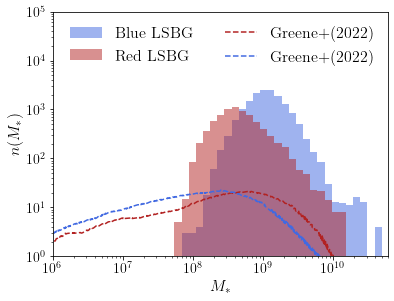

In [45]:
fig = plt.figure(figsize=(6,4.5))
bins = np.logspace(np.log10(1e6), np.log10(1e11), 50)
plt.hist(m_stellar_i_blue_gr, bins=bins, alpha=0.5, color='royalblue', label='Blue LSBG')
plt.hist(m_stellar_i_red_gr, bins=bins, alpha=0.5, color='firebrick', label='Red LSBG')
plt.plot(greene_m_red, greene_red, color='firebrick', ls='--', label='Greene+(2022)')
plt.plot(greene_m_blue, greene_blue, color='royalblue', ls='--', label='Greene+(2022)')
plt.xlabel('$M_*$', fontsize=16)
plt.ylabel('$n(M_*)$', fontsize=16)
plt.xlim(1e6, 6e10)
plt.ylim(1e0, 1e5)
plt.legend(frameon=False, fontsize=16, loc='upper right', ncol=2)
plt.tick_params(axis='both', labelsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()

## Parametrized Stellar-Halo-Mass Relation

We call functions to calculate and plot the various parameterized stellar-halo mass relations. 

### Moster+2010

We compare the [Moster+2010](https://arxiv.org/abs/0903.4682) stellar-to-subhalo-mass relation to the red LSBG stellar-to-halo-mass relation and the [Moster+2010](https://arxiv.org/abs/0903.4682) stellar-to-halo-mass relation to the blue LSBG stellar-to-halo-mass relation. 

We produce an array of stellar masses corresponding to a discrete array of halo masses by using the SsHMR and the SHMR for both satellite and central galaxies. 

In [46]:
m_stellar_sshmr_satellite = parameterized_shmr(m_halo=m_halo_arr_disc, A=A_sat, M_char=M_char_sat, beta=beta_sat, gamma=gamma_sat)

In [47]:
m_stellar_shmr_central = parameterized_shmr(m_halo=m_halo_arr_disc, A=A_cen, M_char=M_char_cen, beta=beta_cen, gamma=gamma_cen)

We resample the parameterized [Moster+2010](https://arxiv.org/abs/0903.4682) SsHMR and SHMR over the uncertainties in their parameters. 

In [48]:
sampled_stellar_mass_sat_sshmr = shmr_param_resampled(A=A_sat, A_err=A_sat_err, M_char=M_char_sat, M_char_err=M_char_sat_err, 
                          beta=beta_sat, beta_err = beta_sat_err, gamma=gamma_sat, gamma_err=gamma_sat_err, halo_mass_range = halo_mass_range)

sampled_stellar_mass_cen_shmr = shmr_param_resampled(A=A_cen, A_err=A_cen_err, M_char=M_char_cen, M_char_err=M_char_cen_err, 
                          beta=beta_cen, beta_err = beta_cen_err, gamma=gamma_cen, gamma_err=gamma_cen_err, halo_mass_range = halo_mass_range)


We define the spread of the [Moster+2010](https://arxiv.org/abs/0903.4682) SsHMR and SHMR using the resampled SsHMR and SHMR stellar masses.

In [49]:
spread_mstellar_sat_arr, spread_sshmr_sat_arr = shmr_spread(halo_mass_range=halo_mass_range, 
                                    sampled_mstellar_shmr=sampled_stellar_mass_sat_sshmr)
spread_mstellar_cen_arr, spread_shmr_cen_arr = shmr_spread(halo_mass_range=halo_mass_range, 
                                    sampled_mstellar_shmr=sampled_stellar_mass_cen_shmr)


We define the bounds of the spread of the [Moster+2010](https://arxiv.org/abs/0903.4682) parameterized SHMR for both satellite and central galaxies. 

In [50]:
y_min_mstellar_sat_spread = spread_mstellar_sat_arr[:,0]
y_max_mstellar_sat_spread = spread_mstellar_sat_arr[:,1]

y_min_sshmr_sat_spread = spread_sshmr_sat_arr[:,0]
y_max_sshmr_sat_spread = spread_sshmr_sat_arr[:,1]


y_min_mstellar_cen_spread = spread_mstellar_cen_arr[:,0]
y_max_mstellar_cen_spread = spread_mstellar_cen_arr[:,1]

y_min_shmr_cen_spread = spread_shmr_cen_arr[:,0]
y_max_shmr_cen_spread = spread_shmr_cen_arr[:,1]

### Danieli+2023

We calculate the stellar mass corresponding to the [Danieli+2023](https://arxiv.org/pdf/2210.14233) definition of the SHMR.

In [51]:
m_stellar_danieli = sshmr_danieli(epsilon, m_char_danieli, alpha_danieli, beta_danieli, gamma_danieli, delta_danieli, m_halo_arr_disc)


### Thornton+2023

We define the uncertainties and values used for the [Thornton+2023](https://arxiv.org/pdf/2311.14659) SHMR estimates for dwarf galaxies. 

In [52]:
thornton_stellar_mass = np.array([10**(8.43), 10**(8.99), 10**9.47])
thornton_stellar_mass_err_pos = np.array([(10**(8.43+0.88)-(10**8.43)), (10**(8.99+0.68)-(10**8.99)), (10**(9.47+0.64)-(10**9.47))])
thornton_stellar_mass_err_neg = np.array([10**8.43 - 10**(8.43-0.88), 10**8.99 - 10**(8.99-0.68), 10**9.47 - 10**(9.47-0.64)])


thornton_halo_mass = np.array([10**10.60, 10**10.96, 10**11.35])
thornton_halo_mass_err_pos = np.array([10**(10.60+0.29)-(10**10.60), 10**(10.96+0.20)-(10**10.96), 10**(11.35+0.14)-(10**11.35)])
thornton_halo_mass_err_neg = np.array([10**(10.60)-(10**(10.60-0.29)), 10**10.96-(10**(10.96-0.20)), 10**11.35 - 10**(11.35-0.14)])


### Mass Definition Conversion

We convert the current halo mass definitions from $M_{200c}$ to the virial mass, based on the means of the LSBG redshift distributions. 

In [53]:
#Means of redshift distributions
zl_mean_red = 0.042 
zl_mean_blue = 0.092

#Halo mass conversion
m_halo_vir, r_vir, c_vir = mass_defs.changeMassDefinition(m_halo_red, concentration.concentration(m_halo_red, '200c', zl_mean_red, 'ishiyama21'), zl_mean_red, '200c', 'vir')
m_halo_vir_blue, r_vir_blue, c_vir_blue = mass_defs.changeMassDefinition(m_halo_blue, concentration.concentration(m_halo_blue, '200c', zl_mean_blue, 'ishiyama21'), zl_mean_blue, '200c', 'vir')

### Final Plot

We plot the LSBG SHMR and compare to the [Moster+2010](https://arxiv.org/abs/0903.4682) parameterized SHMRs, the [Danieli+2023](https://arxiv.org/pdf/2210.14233) parameterized SHMR, the [Mao+2021](https://iopscience.iop.org/article/10.3847/1538-4357/abce58) satellite galaxy stellar mass estimate, the [van Dokkum+2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...828L...6V/abstract) SHMR, the [Sifon+2018](https://arxiv.org/pdf/1704.07847) SHMR upper bound, and the [Thornton+2023](https://arxiv.org/pdf/2311.14659) SHMR. 

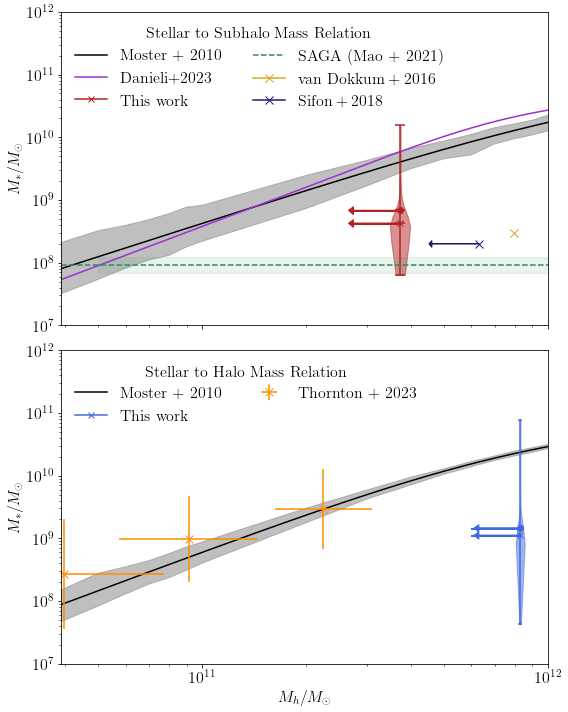

In [54]:
#Defining subhalo range and array of x-axis values for plotting
subhalo_range = np.linspace(3.9e10, m_halo_vir, 100)
median_stellar_line = np.array([np.median(m_stellar_i_red_gr)]*100)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,10), tight_layout=True)

#Parameterized Moster+(2010) stellar-subhalo mass relation, for satellite galaxies
axs[0].fill_between(halo_mass_range, y_min_mstellar_sat_spread, y_max_mstellar_sat_spread, color='grey', alpha=0.5)
axs[0].plot(m_halo_arr_disc, m_stellar_sshmr_satellite, color='black', label='Moster + 2010')

#Parameterized Danieli+(2023) stellar-subhalo mass relation, for satellite galaxies
axs[0].plot(m_halo_arr_disc, m_stellar_danieli, color='darkorchid', label='Danieli+2023')

#This work's red LSBG stellar-subhalo mass relation
parts=axs[0].violinplot(m_stellar_i_red_gr, positions=[m_halo_vir], widths=0.5e11, showmeans=True, showmedians=True)
axs[0].plot(m_halo_vir, np.median(m_stellar_i_red_gr), marker='x', color='firebrick', label='$\\mathrm{This~work}$')
axs[0].plot(m_halo_vir, np.mean(m_stellar_i_red_gr), marker='o', color='firebrick')
axs[0].arrow(m_halo_vir, np.median(m_stellar_i_red_gr), -1e11, 0, head_width=1.2e8, head_length=9e9, color='firebrick')
axs[0].arrow(m_halo_vir, np.mean(m_stellar_i_red_gr), -1e11, 0, head_width=2e8, head_length=9e9, color='firebrick')
axs[0].fill_between((2.7e11, m_halo_vir), bootstrap_med_lower_m_stellar_red_i_gr, bootstrap_med_upper_m_stellar_red_i_gr, color='firebrick')
axs[0].fill_between((2.7e11, m_halo_vir), bootstrap_mean_lower_m_stellar_red_i_gr, bootstrap_mean_upper_m_stellar_red_i_gr, color='firebrick')
for pc in parts['bodies']:
    pc.set_facecolor('firebrick')
    pc.set_edgecolor('firebrick')
    pc.set_alpha(0.5)
parts['cmedians'].set_color('firebrick')
parts['cmaxes'].set_color('firebrick')
parts['cmins'].set_color('firebrick') 
parts['cmeans'].set_color('firebrick')
parts['cbars'].set_color('firebrick')


#SAGA (Mao+(2021)) stellar mass estimate (dwarf, satellite galaxies)
axs[0].fill_betweenx((69183097.09189363, 123026877.0812381), 5e10, 1e13, color='seagreen', alpha=0.1)
axs[0].axhline(y=93325430.07969905, color='seagreen', ls = '--', label='SAGA (Mao + 2021)')

#Sifon+(2018) SHMR (Ultra-Diffuse Galaxies)
axs[0].errorbar(10**11.80, 2e8, marker='x', markersize=8, color='midnightblue', label='$\\mathrm{Sifon + 2018}$')
axs[0].arrow(10**11.80, 2e8, -1.7e11, 0, head_width=0.5e8, head_length=9e9, color='midnightblue')

#Van Dokkum+(2016) (Dragonfly 44)
axs[0].plot(10**11.90, 3e8, marker='x', markersize=8, color='goldenrod', label='$\\mathrm{van~Dokkum + 2016}$')

#Moster+(2010) stellar-halo mass relation, for central galaxies
axs[1].fill_between(halo_mass_range, y_min_mstellar_cen_spread, y_max_mstellar_cen_spread, color='grey', alpha=0.5)
axs[1].plot(m_halo_arr_disc, m_stellar_shmr_central, color='black',  label='Moster + 2010')

#This work's blue LSBG stellar-halo mass relation
parts_blue=axs[1].violinplot(m_stellar_i_blue_gr, positions=[m_halo_vir_blue], widths=0.5e11, showmeans=True, showmedians=True)
axs[1].plot(m_halo_vir_blue, np.median(m_stellar_i_blue_gr), marker='x', color='royalblue', label='$\\mathrm{This~work}$')
axs[1].plot(m_halo_vir_blue, np.mean(m_stellar_i_blue_gr), marker='o', color='royalblue')
for pc_blue in parts_blue['bodies']:
    pc_blue.set_facecolor('royalblue')
    pc_blue.set_edgecolor('royalblue')
    pc_blue.set_alpha(0.5)
parts_blue['cmedians'].set_color('royalblue')
parts_blue['cmaxes'].set_color('royalblue') 
parts_blue['cmins'].set_color('royalblue') 
parts_blue['cmeans'].set_color('royalblue')
parts_blue['cbars'].set_color('royalblue')
axs[1].fill_between((6e11, m_halo_vir_blue), bootstrap_med_lower_m_stellar_blue_i_gr, bootstrap_med_upper_m_stellar_blue_i_gr, color='royalblue')
axs[1].fill_between((6e11, m_halo_vir_blue), bootstrap_mean_lower_m_stellar_blue_i_gr, bootstrap_mean_upper_m_stellar_blue_i_gr, color='royalblue')
axs[1].arrow(m_halo_vir_blue, np.median(m_stellar_i_blue_gr), -2e11, 0, head_width=3e8, head_length=2e10, color='royalblue')
axs[1].arrow(m_halo_vir_blue, np.mean(m_stellar_i_blue_gr), -2e11, 0, head_width=4e8, head_length=2e10, color='royalblue')

#Thornton+(2023) stellar-halo mass relation
axs[1].errorbar(thornton_halo_mass, thornton_stellar_mass,  yerr=[thornton_stellar_mass_err_neg, thornton_stellar_mass_err_pos], xerr=[thornton_halo_mass_err_neg, thornton_halo_mass_err_pos], fmt='x', markersize=8, color='darkorange', label='Thornton + 2023')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_h/M_{\odot}$', fontsize=16)
axs[0].set_ylabel('$M_*/M_{\odot}$', fontsize=16)
axs[1].set_ylabel('$M_*/M_{\odot}$', fontsize=16)
plt.xlim(3.9e10, 1e12)
plt.ylim(1e7, 1e12)
axs[0].legend(frameon=False, fontsize=16, loc='upper left', ncol=2, title='Stellar to Subhalo Mass Relation', title_fontsize=16)
axs[1].legend(frameon=False, fontsize=16, loc='upper left', ncol=2, title='Stellar to Halo Mass Relation', title_fontsize=16)
axs[0].tick_params(axis='both', labelsize=16)
axs[1].tick_params(axis='both', labelsize=16)
plt.show()